In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'..')
from datagenerator_realistic import jet_data_generator 
import time
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

In [3]:
sys.path.insert(0,'../training')
from manifoldembedder import JetDataset, JetPredictDataset
from torch.utils.data import DataLoader, random_split


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [5]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

In [6]:
#top_2p_8part = jet_data_generator("signal", 2, 8, True)
top_2p_8part = jet_data_generator("signal", 2, 8, True,True, 2)

In [56]:
data, z, randtheta = top_2p_8part.generate_dataset(100)

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pylorentz/__init__.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._values = np.array(list(x))
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pylorentz/__init__.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._values = np.array(list(x))
/home/sangeon/ToyJetGenerator/data/../datagenerator_realistic.py:326: RuntimeWarning: invalid value encountered in sqrt
  return np.arctan(np.sqrt(num/den))
/home/sangeon/ToyJetGener

In [57]:
#with open('test.pickle', 'wb') as handle:
#    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
#    pickle.dump(z, handle, protocol=pickle.HIGHEST_PROTOCOL)
#    pickle.dump(randtheta, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('test.pickle', 'rb') as handle:
    a= pickle.load(handle)
    b= pickle.load(handle)
    c= pickle.load(handle)

In [61]:
a.shape

(100, 24)

In [62]:
b.shape

(100, 7)

In [7]:
np.array([1,2,3]).shape

(3,)

In [7]:
def plot_multiple_jets(ax, pfcands, index):

    pt = pfcands[:,2]
    eta = pfcands[:,0]
    phi = pfcands[:,1]
    #fig = plt.figure()
    #ax = fig.add_subplot(1,1,1)
    ax[index].scatter(eta,phi,s=pt*1000, alpha=0.2)
    #ax.set_xlabel('deta')
    #ax.set_ylabel('dphi')
    ax[index].set_xlim([-4,4])
    ax[index].set_ylim([-4,4])

In [8]:
def plot_event(pfcands, path, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*20, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    #fig.savefig(f'{path}/{name}.png')

In [9]:
def get_emd_and_jets(dataset_len, set1, set2, npart):
    jets_set1 = np.empty([0, 16, 3])
    jets_set2 = np.empty([0, 16, 3])
    set_ab = JetDataset(False, None, True, set1,set2[np.random.permutation(dataset_len)],npart)
    loader = DataLoader(set_ab, batch_size=2000,shuffle=False,num_workers=4)
    emd = np.array([])
    for x,y,dist in loader:
        jets_set1 = np.concatenate([jets_set1, x.data.numpy()])
        jets_set2 = np.concatenate([jets_set2, y.data.numpy()])
        emd = np.concatenate([emd,dist.data.numpy()])
    return emd, jets_set1, jets_set2

In [10]:
def get_emd_dist(dataset_len, set1, set2, npart):
    set_ab = JetDataset(False, None, True, set1,set2[np.random.permutation(dataset_len)],npart)
    loader = DataLoader(set_ab, batch_size=2000,shuffle=False,num_workers=4)
    emd = np.array([])
    for x,y,dist in loader:
        emd = np.concatenate([emd,dist.data.numpy()])
    return emd

In [7]:
rawjetdir = '/nobackup/users/sangeon/datasets/jets/rawjets/realistic'
type_arr  = ['1p','2p','3p','4p']
set_list = []
for jettype in type_arr:
    with open(os.path.join(rawjetdir, f'realistic_rawjet_test_{jettype}_16part_merged.pickle'),'rb') as handle:
        A = pickle.load(handle)
    set_list.append(A)

In [8]:
set_list[0].shape

(200000, 48)

In [11]:
_, jets_1p, jets_2p = get_emd_and_jets(1000,set_list[0][:1000],set_list[1][:1000],16)
_, jets_3p, jets_4p = get_emd_and_jets(1000,set_list[2][:1000],set_list[3][:1000],16)

100%|██████████| 1/1 [00:08<00:00,  8.24s/it]


In [11]:
idx_list = []

name_list  = ['1p','2p','3p','4p']

pairname_list = []

emd_list = []
for i in range(4):
    for j in range(4):
        if i<=j:
            idx_list.append([i,j])
            pairname_list.append(f'{name_list[i]}-{name_list[j]}')
            emd_list.append(get_emd_dist(1000, set_list[i][:1000], set_list[j][:1000], 16))
        

100%|██████████| 1/1 [00:08<00:00,  8.09s/it]


In [12]:
pairname_list

['1p-1p',
 '1p-2p',
 '1p-3p',
 '1p-4p',
 '2p-2p',
 '2p-3p',
 '2p-4p',
 '3p-3p',
 '3p-4p',
 '4p-4p']

In [15]:
#with open('../figures/paper/plot_data/EMD_ToyRealistic_pairname_list.pickle','wb') as handle:
#    pickle.dump(pairname_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('../figures/paper/plot_data/EMD_ToyRealistic_emd_list.pickle','wb') as handle:
#    pickle.dump(emd_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('../figures/paper/plot_data/EMD_ToyRealistic_pairname_list.pickle','rb') as handle:
    pairname_list = pickle.load(handle)

with open('../figures/paper/plot_data/EMD_ToyRealistic_emd_list.pickle','rb') as handle:
    emd_list = pickle.load(handle)

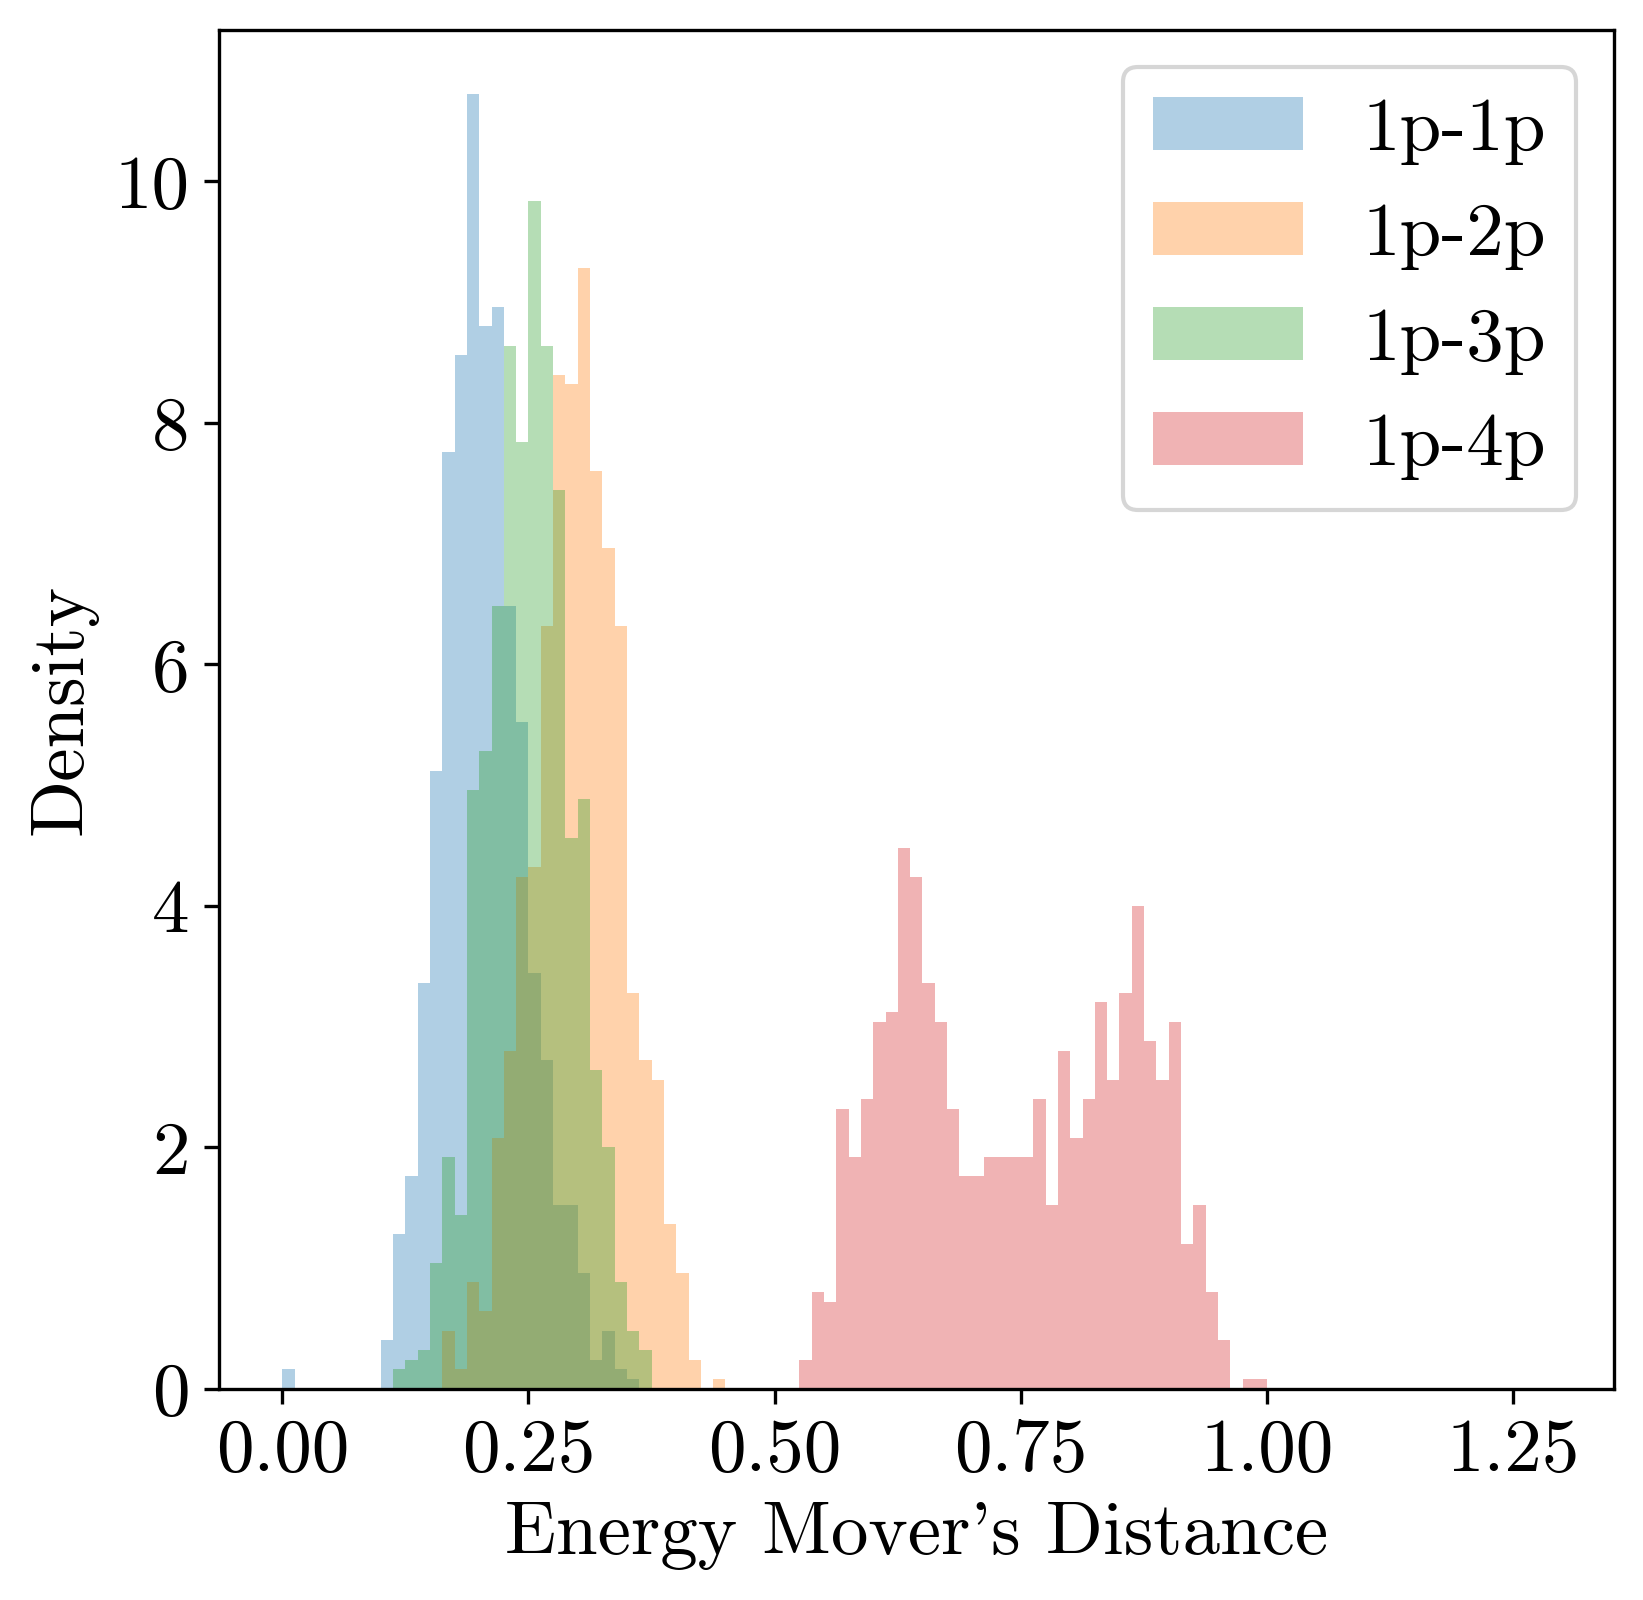

In [12]:
for index in [0,1,2,3]:
    plt.hist(emd_list[index], bins=np.arange(0,1.3,0.0125),alpha=0.35, density=True,label=pairname_list[index]);


plt.xlabel("Energy Mover's Distance")
plt.ylabel("Density")
plt.legend()
figname = 'RealisticToyJet_EMDDistribution_1p'
#plt.title(figname)

plt.savefig(f'../figures/paper_JHEP/{figname}.png')
plt.savefig(f'../figures/paper_JHEP/{figname}.pdf')

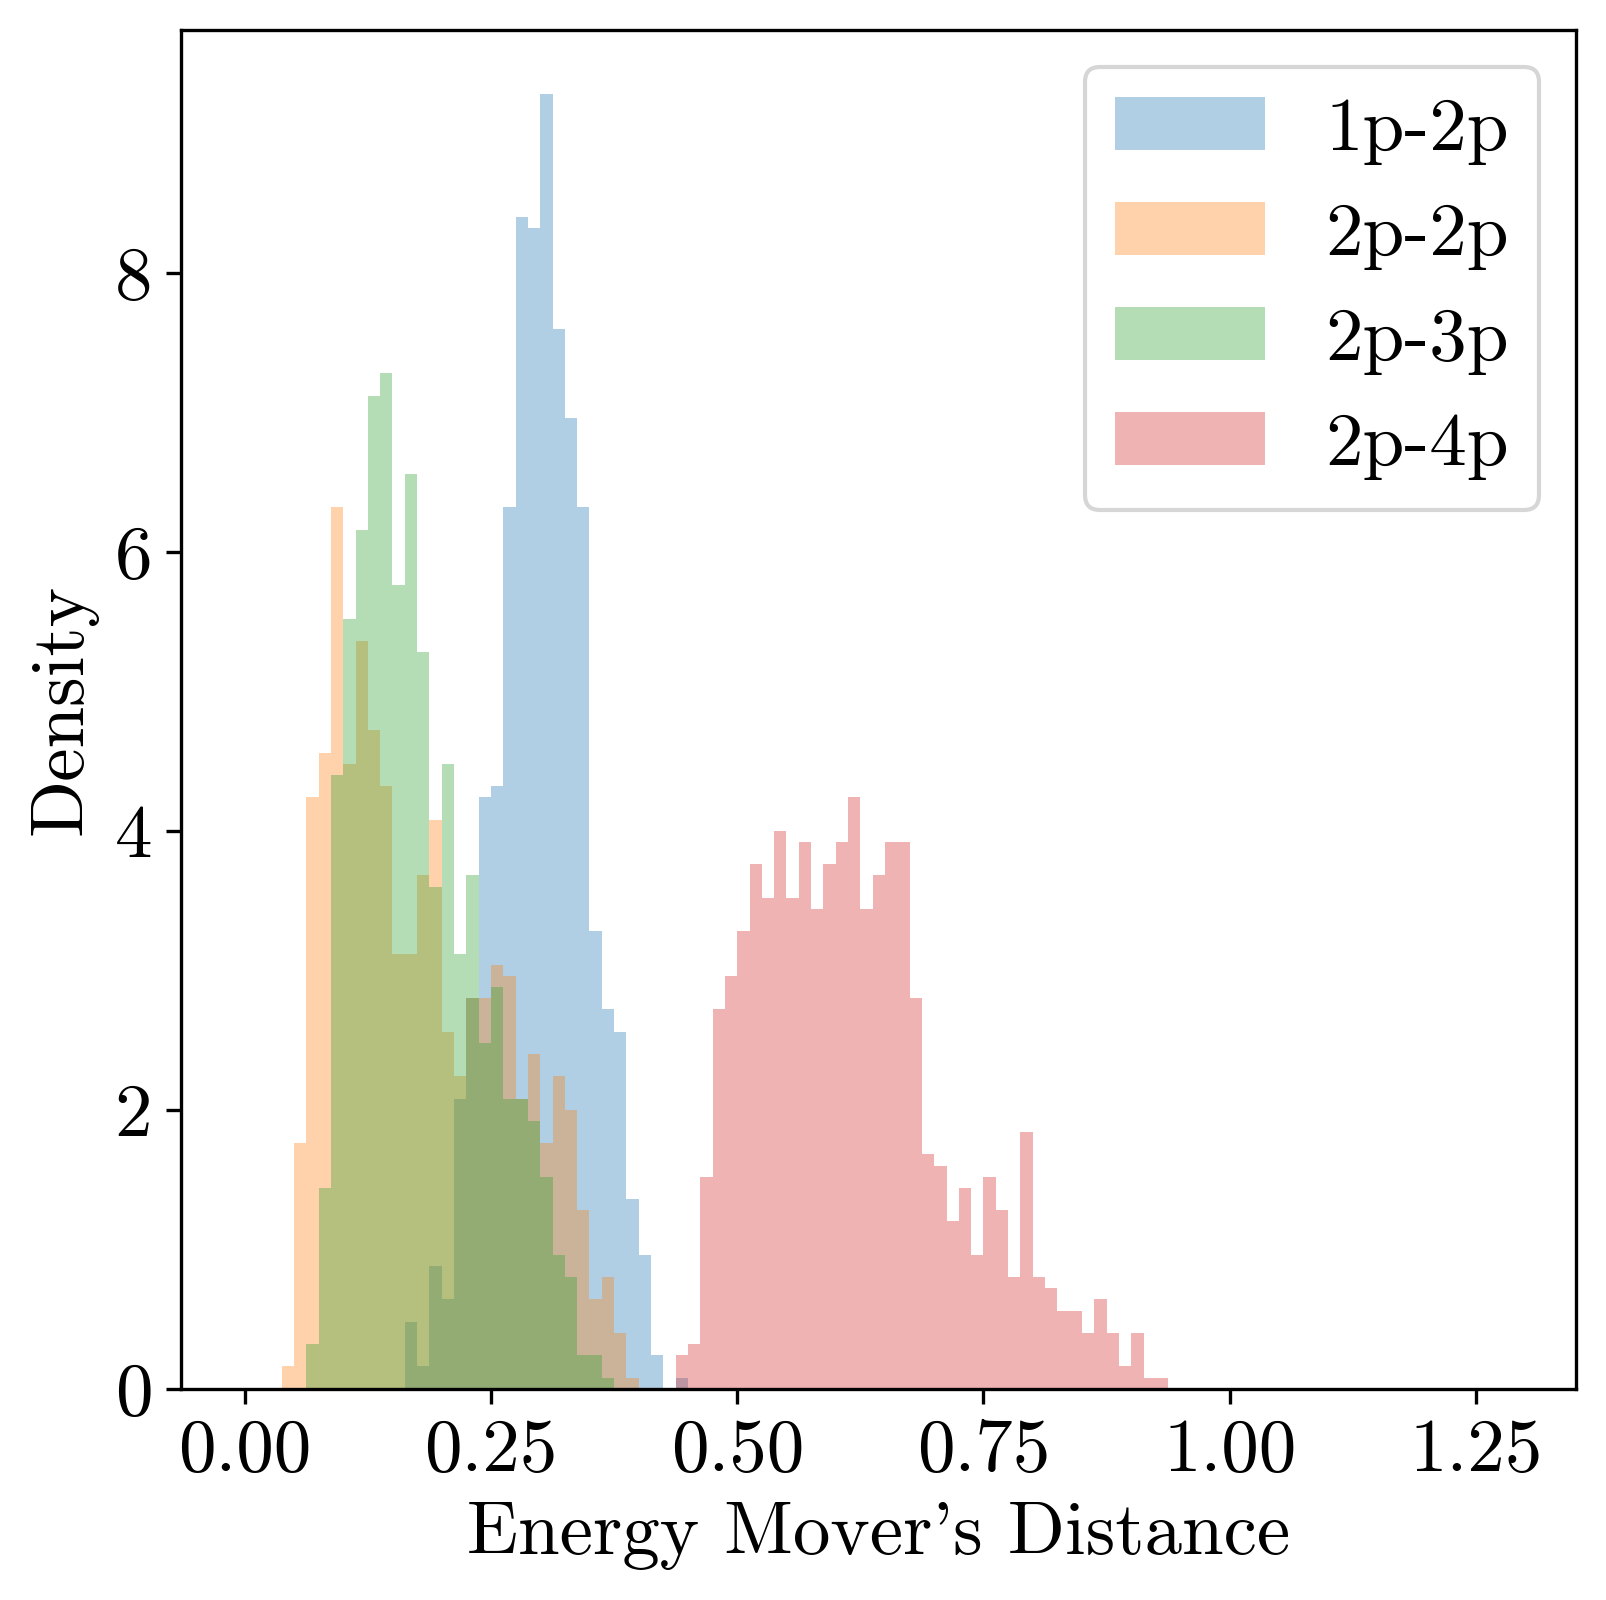

In [13]:
for index in [1,4,5,6]:
    plt.hist(emd_list[index], bins=np.arange(0,1.3,0.0125),alpha=0.35, density=True,label=pairname_list[index]);


plt.xlabel("Energy Mover's Distance")
plt.ylabel("Density")
plt.legend()
figname = 'RealisticToyJet_EMDDistribution_2p'
#plt.title(figname)

plt.savefig(f'../figures/paper_JHEP/{figname}.png')
plt.savefig(f'../figures/paper_JHEP/{figname}.pdf')

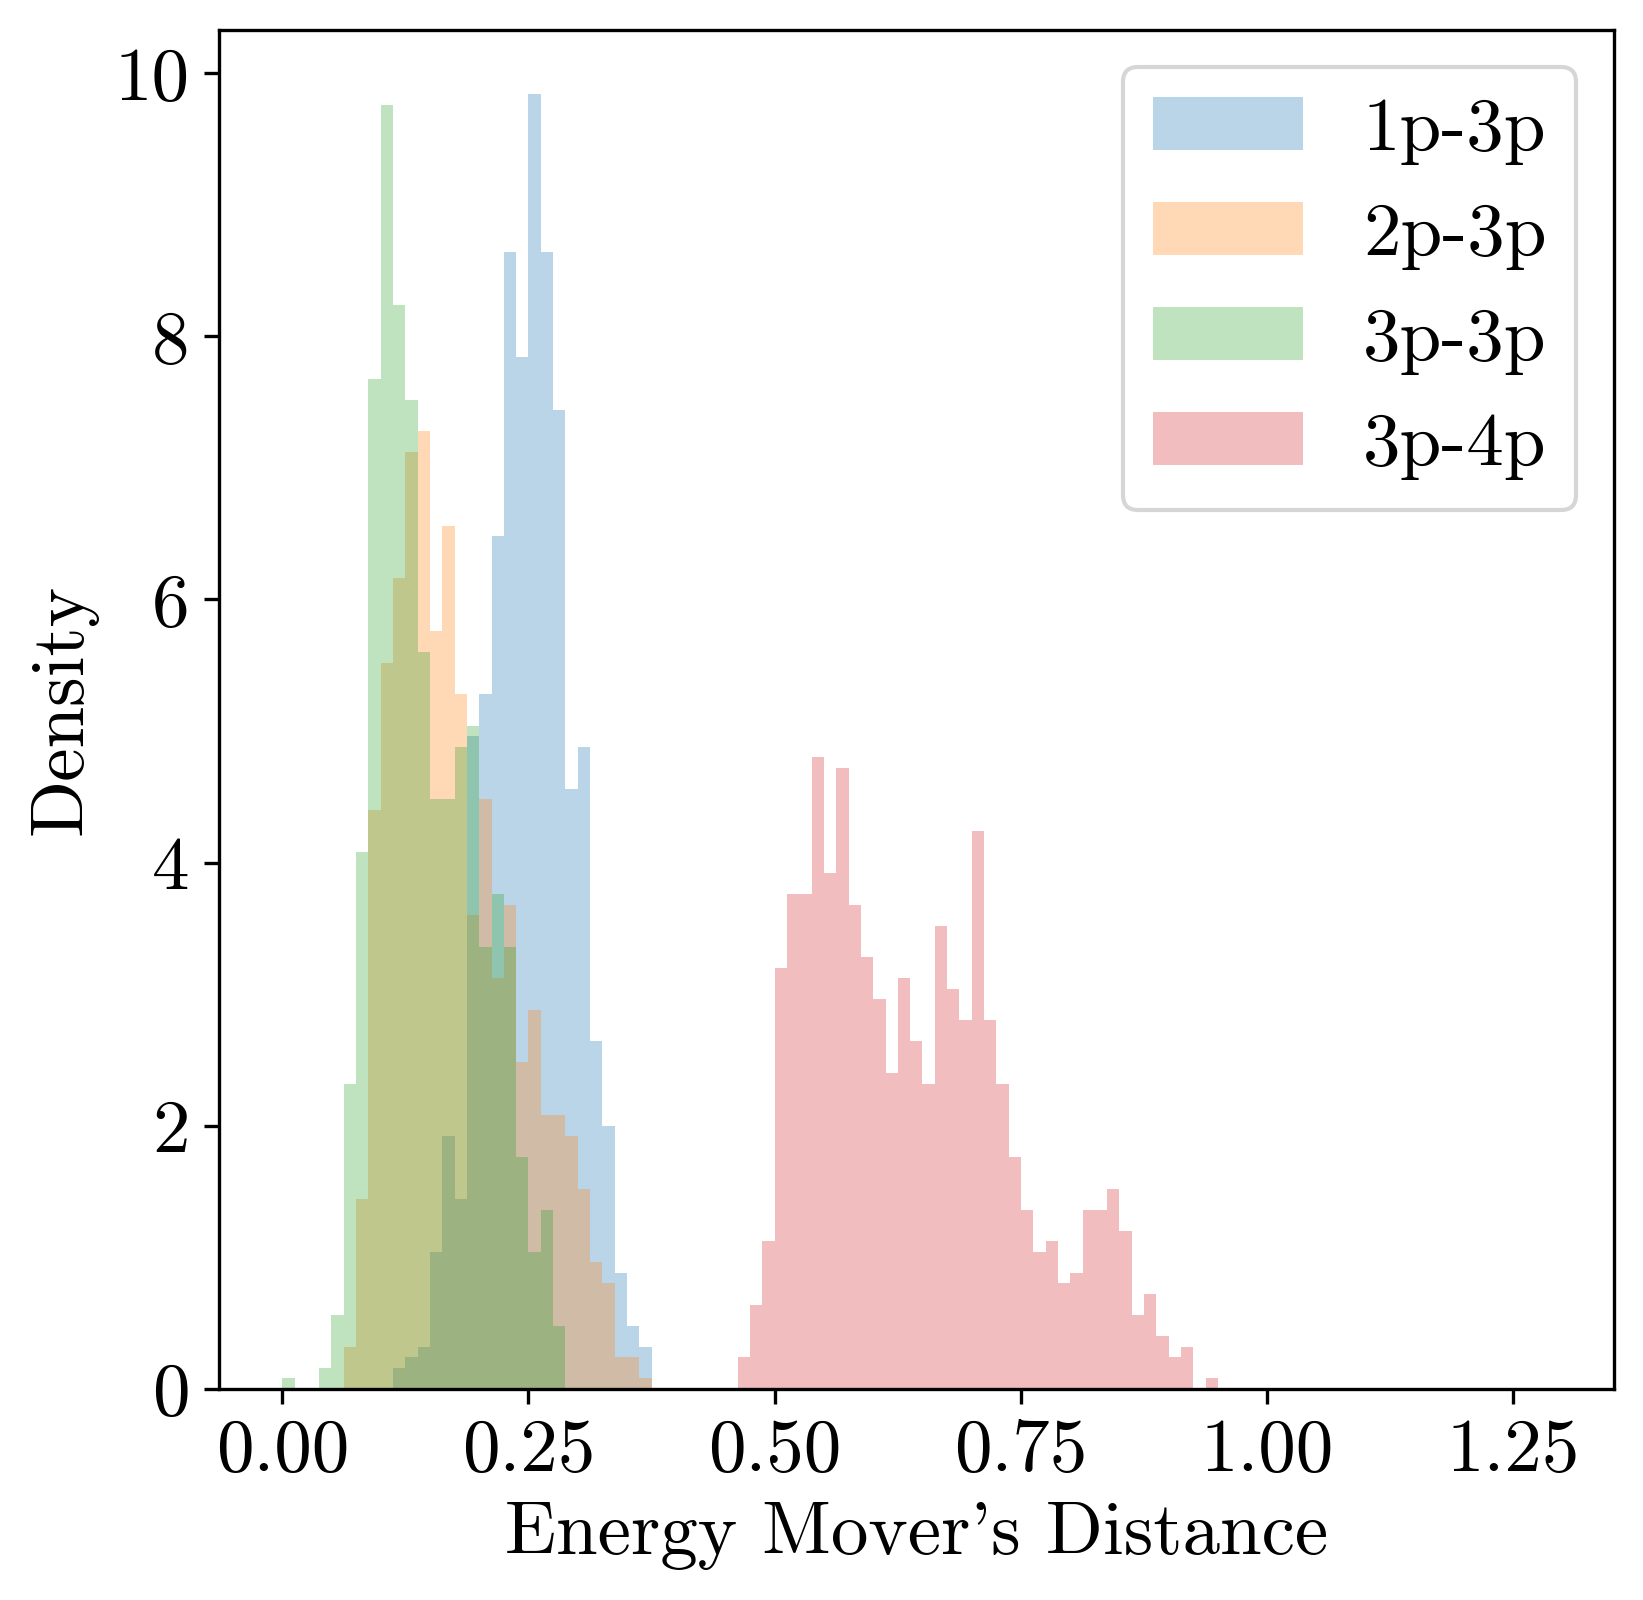

In [14]:
for index in [2,5,7,8]:
    plt.hist(emd_list[index], bins=np.arange(0,1.3,0.0125),alpha=0.3, density=True,label=pairname_list[index]);


plt.xlabel("Energy Mover's Distance")
plt.ylabel("Density")
plt.legend()
figname = 'RealisticToyJet_EMDDistribution_3p'
#plt.title(figname)

plt.savefig(f'../figures/paper_JHEP/{figname}.png')
plt.savefig(f'../figures/paper_JHEP/{figname}.pdf')

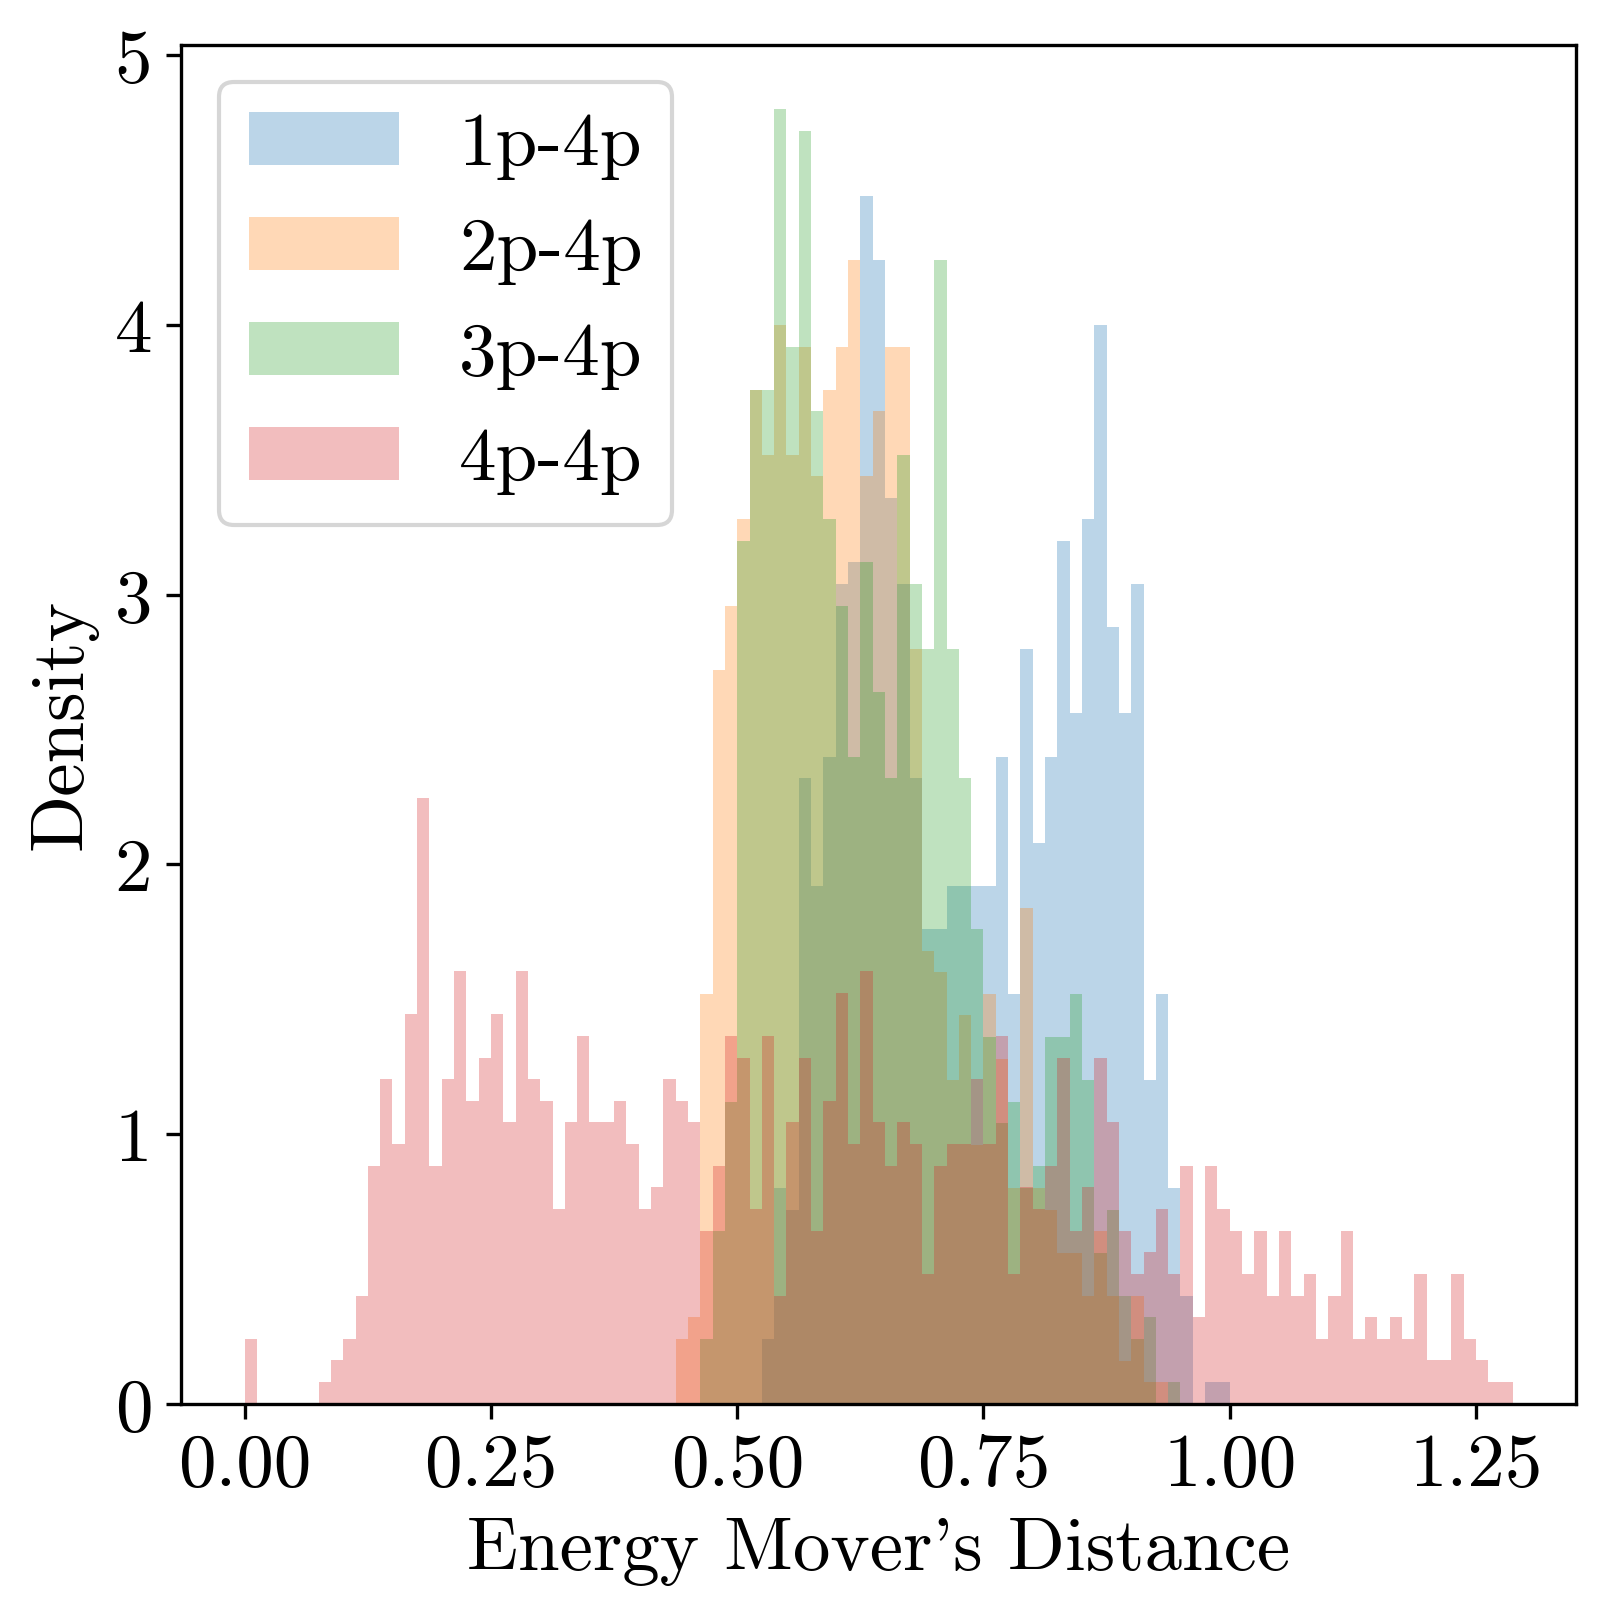

In [18]:
for index in [3,6,8,9]:
    plt.hist(emd_list[index], bins=np.arange(0,1.3,0.0125),alpha=0.3, density=True,label=pairname_list[index]);


plt.xlabel("Energy Mover's Distance")
plt.ylabel("Density")
plt.legend()
figname = 'RealisticToyJet_EMDDistribution_4p'
#plt.title(figname)

plt.savefig(f'../figures/paper_JHEP/{figname}.png')
plt.savefig(f'../figures/paper_JHEP/{figname}.pdf')

In [ ]:
plt.rcParams["figure.figsize"] = (18,15)
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(5, 6, sharex=True, sharey=True)
axs = axs.ravel()
for i in range(30):
    plot_multiple_jets(axs, jets_3p[i], i)
fig.savefig('../figures/paper/RealisticToyJet_1ap.png')

In [6]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
import matplotlib.pyplot as plt


In [14]:
#set_3p3p = JetDataset(False, None, True, top_3p,top_3p[np.random.permutation(1000)],16)

NameError: name 'top_3p' is not defined

In [21]:
#set_2p2p = JetDataset(False, None, True, top_2p,top_2p[np.random.permutation(1000)],16)

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


In [22]:
#set_2p3p = JetDataset(False, None, True, top_2p,top_3p,16)

100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


In [10]:
set_1p2p = JetDataset(False, None, True, set_list[0][:100],set_list[1][:100],16)
set_3p4p = JetDataset(False, None, True, set_list[2][:100],set_list[3][:100],16)

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


In [11]:
loader = DataLoader(set_1p2p, batch_size=10000,shuffle=False,num_workers=4)
loader2 = DataLoader(set_3p4p, batch_size=10000,shuffle=False,num_workers=4)



In [12]:
emd = np.array([])
jets_1p = np.empty([0, 16, 3])
jets_2p = np.empty([0, 16, 3])
jets_3p = np.empty([0, 16, 3])
jets_4p = np.empty([0, 16, 3])
for x,y,dist in loader:
    jets_1p = np.concatenate([jets_1p, x.data.numpy()])
    jets_2p = np.concatenate([jets_2p, y.data.numpy()])
    #emd = np.concatenate([emd,dist.data.numpy()])

for x,y,dist in loader2:
    jets_3p = np.concatenate([jets_3p, x.data.numpy()])
    jets_4p = np.concatenate([jets_4p, y.data.numpy()])
#emd2 = np.array([])
#for x,y,dist in loader2:
    #emd2 = np.concatenate([emd2,dist.data.numpy()])

#emd3 = np.array([])
#for x,y,dist in loader3:
#    emd3 = np.concatenate([emd3,dist.data.numpy()])

In [13]:
jets_2p_rot = np.rot90(jets_2p, k=0)

In [14]:
jets_2p[0]

array([[ 0.47064149,  0.06949955,  0.0684369 ],
       [-0.18096504, -0.01069679,  0.35841534],
       [-0.19153611, -0.01564649,  0.03998936],
       [-0.18268807, -0.03326822,  0.02270069],
       [ 0.64416927,  0.09671503,  0.02323673],
       [ 0.82880998,  0.17156798,  0.02319335],
       [ 0.68107146,  0.00635585,  0.01131009],
       [-0.15674806,  0.01031227,  0.01641714],
       [-0.20023756,  0.03806552,  0.16041276],
       [-0.16071421, -0.00853462,  0.0118186 ],
       [-0.17482275, -0.0116537 ,  0.01064102],
       [-0.1813622 ,  0.01082212,  0.00870618],
       [ 0.96831185, -0.19754736,  0.0561892 ],
       [-0.13925198, -0.03631535,  0.07104268],
       [-0.17452568, -0.01813966,  0.01080063],
       [-0.12501661,  0.01730793,  0.10668935]])

In [15]:
jets_2p_rot[0]

array([[ 0.47064149,  0.06949955,  0.0684369 ],
       [-0.18096504, -0.01069679,  0.35841534],
       [-0.19153611, -0.01564649,  0.03998936],
       [-0.18268807, -0.03326822,  0.02270069],
       [ 0.64416927,  0.09671503,  0.02323673],
       [ 0.82880998,  0.17156798,  0.02319335],
       [ 0.68107146,  0.00635585,  0.01131009],
       [-0.15674806,  0.01031227,  0.01641714],
       [-0.20023756,  0.03806552,  0.16041276],
       [-0.16071421, -0.00853462,  0.0118186 ],
       [-0.17482275, -0.0116537 ,  0.01064102],
       [-0.1813622 ,  0.01082212,  0.00870618],
       [ 0.96831185, -0.19754736,  0.0561892 ],
       [-0.13925198, -0.03631535,  0.07104268],
       [-0.17452568, -0.01813966,  0.01080063],
       [-0.12501661,  0.01730793,  0.10668935]])

In [16]:
def plot_multiple_jets(ax, pfcands, index, color):

    pt = pfcands[:,2]
    eta = pfcands[:,0]
    phi = pfcands[:,1]
    #fig = plt.figure()
    #ax = fig.add_subplot(1,1,1)
    ax[index].scatter(phi,-eta,s=pt*1000, alpha=0.2, color=color)
    #ax.set_xlabel('deta')
    #ax.set_ylabel('dphi')
    ax[index].set_xlim([-4,4])
    ax[index].set_ylim([-4,4])

In [21]:
plt.rcParams["figure.figsize"] = (18,15)
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(5, 6, sharex=True, sharey=True, dpi=600)
axs = axs.ravel()
for i in range(30):
    plot_multiple_jets(axs, jets_1p[i], i, 'C0')
    
fig = plt.gcf()
st = fig.suptitle("Realistic Toy Jet 1-prong", fontsize="x-large")
st.set_y(0.88)
fig.subplots_adjust(top=0.85)

fig.savefig('../figures/paper/Examples_RealisticToyJet_1p.png')
fig.savefig('../figures/paper/Examples_RealisticToyJet_1p.pdf')

In [22]:
plt.rcParams["figure.figsize"] = (18,15)
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(5, 6, sharex=True, sharey=True, dpi=600)
axs = axs.ravel()
for i in range(30):
    plot_multiple_jets(axs, jets_2p_rot[i], i, 'C1')
    
fig = plt.gcf()
st = fig.suptitle("Realistic Toy Jet 2-prong", fontsize="x-large")
st.set_y(0.88)
fig.subplots_adjust(top=0.85)

fig.savefig('../figures/paper/Examples_RealisticToyJet_2p.png')
fig.savefig('../figures/paper/Examples_RealisticToyJet_2p.pdf')

In [23]:
plt.rcParams["figure.figsize"] = (18,15)
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(5, 6, sharex=True, sharey=True, dpi=600)
axs = axs.ravel()
for i in range(30):
    plot_multiple_jets(axs, jets_3p[i], i, 'C2')
    
fig = plt.gcf()
st = fig.suptitle("Realistic Toy Jet 3-prong", fontsize="x-large")
st.set_y(0.88)
fig.subplots_adjust(top=0.85)

fig.savefig('../figures/paper/Examples-RealisticToyJet_3p.png')
fig.savefig('../figures/paper/Examples-RealisticToyJet_3p.pdf')

In [24]:
plt.rcParams["figure.figsize"] = (18,15)
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(5, 6, sharex=True, sharey=True, dpi=600)
axs = axs.ravel()
for i in range(30):
    plot_multiple_jets(axs, jets_4p[i], i, 'C3')
    
fig = plt.gcf()
st = fig.suptitle("Realistic Toy Jet 4-prong", fontsize="x-large")
st.set_y(0.88)
fig.subplots_adjust(top=0.85)

fig.savefig('../figures/paper/Examples_RealisticToyJet_4p.png')
fig.savefig('../figures/paper/Examples_RealisticToyJet_4p.pdf')

In [ ]:
for i in tqdm(range(0,120)):
    data_top_5p_8part = top_5p_8part.generate_dataset(100000)
    print('finished generation')
    with open(f'top_5p_8part_fixedp_{i}.pickle', 'wb') as handle:
        pickle.dump(data_top_5p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'saved file {i}')
    

  1%|          | 1/120 [05:03<10:01:18, 303.18s/it]

finished generation
saved file 0


  2%|▏         | 2/120 [10:16<10:07:46, 309.04s/it]

finished generation
saved file 1


  2%|▎         | 3/120 [15:25<10:02:57, 309.21s/it]

finished generation
saved file 2


  3%|▎         | 4/120 [20:28<9:52:38, 306.54s/it] 

finished generation
saved file 3


  4%|▍         | 5/120 [25:33<9:46:50, 306.18s/it]

finished generation
saved file 4


  5%|▌         | 6/120 [30:33<9:37:37, 304.01s/it]

finished generation
saved file 5


  6%|▌         | 7/120 [35:22<9:23:25, 299.17s/it]

finished generation
saved file 6


  7%|▋         | 8/120 [40:18<9:16:22, 298.06s/it]

finished generation
saved file 7


  8%|▊         | 9/120 [45:07<9:06:02, 295.15s/it]

finished generation
saved file 8


  8%|▊         | 10/120 [50:01<9:00:23, 294.76s/it]

finished generation
saved file 9


  9%|▉         | 11/120 [55:13<9:05:19, 300.18s/it]

finished generation
saved file 10


 10%|█         | 12/120 [1:00:20<9:04:11, 302.32s/it]

finished generation
saved file 11


 11%|█         | 13/120 [1:05:23<8:59:10, 302.34s/it]

finished generation
saved file 12


 12%|█▏        | 14/120 [1:10:29<8:56:17, 303.56s/it]

finished generation
saved file 13


 12%|█▎        | 15/120 [1:15:37<8:53:34, 304.90s/it]

finished generation
saved file 14


 13%|█▎        | 16/120 [1:20:49<8:52:11, 307.03s/it]

finished generation
saved file 15


 14%|█▍        | 17/120 [1:25:56<8:47:07, 307.06s/it]

finished generation
saved file 16


 15%|█▌        | 18/120 [1:31:00<8:40:28, 306.16s/it]

finished generation
saved file 17


 16%|█▌        | 19/120 [1:35:58<8:31:18, 303.75s/it]

finished generation
saved file 18


 17%|█▋        | 20/120 [1:40:55<8:22:32, 301.53s/it]

finished generation
saved file 19


 18%|█▊        | 21/120 [1:45:48<8:13:39, 299.19s/it]

finished generation
saved file 20


 18%|█▊        | 22/120 [1:50:35<8:02:18, 295.29s/it]

finished generation
saved file 21


 19%|█▉        | 23/120 [1:55:32<7:58:36, 296.05s/it]

finished generation
saved file 22


 20%|██        | 24/120 [2:00:46<8:02:18, 301.44s/it]

finished generation
saved file 23


 21%|██        | 25/120 [2:05:32<7:49:44, 296.68s/it]

finished generation
saved file 24


 22%|██▏       | 26/120 [2:10:31<7:45:49, 297.33s/it]

finished generation
saved file 25


 22%|██▎       | 27/120 [2:15:30<7:41:40, 297.85s/it]

finished generation
saved file 26


 23%|██▎       | 28/120 [2:20:29<7:37:16, 298.22s/it]

finished generation
saved file 27


 24%|██▍       | 29/120 [2:25:23<7:30:23, 296.96s/it]

finished generation
saved file 28


 25%|██▌       | 30/120 [2:30:08<7:19:55, 293.29s/it]

finished generation
saved file 29


 26%|██▌       | 31/120 [2:35:00<7:14:36, 293.00s/it]

finished generation
saved file 30


 27%|██▋       | 32/120 [2:39:50<7:08:32, 292.19s/it]

finished generation
saved file 31


 28%|██▊       | 33/120 [2:44:52<7:07:39, 294.94s/it]

finished generation
saved file 32


In [6]:
top_2p_8part = jet_data_generator("signal",0.00005, 2, 8, True,True, 4)

In [7]:
for i in tqdm(range(56,60)):
    data_top_2p_8part = top_2p_8part.generate_dataset(100000)
    print('finished generation')
    with open(f'top_2p_8part_fixedp_{i}.pickle', 'wb') as handle:
        pickle.dump(data_top_2p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'saved file {i}')
    

 25%|██▌       | 1/4 [04:37<13:52, 277.59s/it]

finished generation
saved file 56


 50%|█████     | 2/4 [09:14<09:13, 276.98s/it]

finished generation
saved file 57


 75%|███████▌  | 3/4 [13:50<04:36, 276.63s/it]

finished generation
saved file 58


100%|██████████| 4/4 [18:26<00:00, 276.66s/it]

finished generation
saved file 59


In [4]:
#with open('top_2p_8part_fixedp_test.pickle', 'wb') as handle:
#    pickle.dump(data_top_2p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
top_3p_8part = jet_data_generator("signal",0.00005, 3, 8, True,True,4)

In [ ]:
for i in tqdm(range(99,110)):
    data_top_3p_8part = top_3p_8part.generate_dataset(100000)
    print('finished generation')
    with open(f'top_3p_8part_fixedp_{i}.pickle', 'wb') as handle:
        pickle.dump(data_top_3p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'saved file {i}')

  9%|▉         | 1/11 [04:39<46:39, 279.91s/it]

finished generation
saved file 99


 18%|█▊        | 2/11 [09:20<42:04, 280.46s/it]

finished generation
saved file 100


 27%|██▋       | 3/11 [14:01<37:24, 280.53s/it]

finished generation
saved file 101


 36%|███▋      | 4/11 [18:41<32:42, 280.29s/it]

finished generation
saved file 102


 45%|████▌     | 5/11 [23:21<28:01, 280.25s/it]

finished generation
saved file 103


In [3]:
sys.path.insert(0,'../optimal_transport')

from emdloss import *


In [5]:
import time

In [6]:
start = time.time()

1640232511.6718123

In [ ]:
import torch as 

In [ ]:
for i in range(70):
    start = time.time()
    print(f'start{i}')
    with 

In [9]:
start = time.time()
data_top_3p_8part = top_3p_8part.generate_dataset(100000)
end = time.time()
print(end-start)

265.1327540874481


In [10]:
with open('top_3p_8part_fixedp_test.pickle', 'wb') as handle:
    pickle.dump(data_top_3p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('top_2p_8part_fixedp.pickle', 'rb') as handle:
    twop_A = pickle.load(handle)

In [3]:
with open('top_2p_8part_fixedp_prime.pickle', 'rb') as handle:
    twop_B = pickle.load(handle)

In [4]:
with open('top_3p_8part_fixedp.pickle', 'rb') as handle:
    threep_A = pickle.load(handle)

In [5]:
with open('top_3p_8part_fixedp_prime.pickle', 'rb') as handle:
    threep_B= pickle.load(handle)

In [6]:
twoprong = np.concatenate((twop_A, twop_B))

In [7]:
threeprong = np.concatenate((threep_A, threep_B))

In [8]:
def build_two_jet_sets(twop, threep):
    jet1 = np.concatenate((np.random.permutation(twop), np.random.permutation(twop), np.random.permutation(threep), np.random.permutation(threep)))
    jet2 = np.concatenate((np.random.permutation(twop),np.random.permutation(threep),np.random.permutation(twop), np.random.permutation(threep)))
    return jet1, jet2

In [9]:
twop_train, twop_val = train_test_split(twoprong, test_size=0.33)

In [10]:
threep_train, threep_val = train_test_split(threeprong, test_size=0.33)

In [11]:
jettrain1, jettrain2 = build_two_jet_sets(twop_train,threep_train)

In [12]:
jetval1, jetval2 = build_two_jet_sets(twop_val,threep_val)

In [13]:
jettrain1.shape

(536000, 24)

In [14]:
jettrain1.shape

(536000, 24)

In [6]:
twop_A, twop_A_test = train_test_split(twop_A, train_size=80000,test_size=20000)

In [7]:
twop_B, twop_B_test = train_test_split(twop_B, train_size=80000,test_size=20000)

In [8]:
threep_A, threep_A_test = train_test_split(threep_A, train_size=80000,test_size=20000)

In [9]:
threep_B, threep_B_test = train_test_split(threep_B, train_size=80000,test_size=20000)

In [4]:
sys.path.insert(0,'../training')
from manifoldembedder import JetDataset, JetPredictDataset

In [12]:
jet1 = np.concatenate([twop_A, twop_A, threep_A, threep_A])

In [13]:
jet2 = np.concatenate([twop_B, threep_B, twop_B, threep_B])

In [14]:
jet1_test = np.concatenate([twop_A_test, twop_A_test, threep_A_test, threep_A_test])

In [15]:
jet2_test = np.concatenate([twop_B_test, threep_B_test, twop_B_test, threep_B_test])

In [16]:
len(twop_A_test)

20000

In [17]:
jet1_test_label = np.concatenate([np.zeros(40000),np.ones(40000)])

In [18]:
len(jet1_test_label)

80000

In [5]:
import torch

In [ ]:
for i in range(42,100):
    train_set = JetDataset(True, "./", f'top_2p_8part_fixedp_{i}.pickle',f'top_2p_8part_fixedp_{i+1}.pickle',8)
    torch.save(train_set, f'/nobackup/users/sangeon/datasets/jetdataset_8part_2p2p_idx_{i}_{i+1}.pt')
    train_set = JetDataset(True, "./", f'top_3p_8part_fixedp_{i}.pickle',f'top_3p_8part_fixedp_{i+1}.pickle',8)
    torch.save(train_set, f'/nobackup/users/sangeon/datasets/jetdataset_8part_3p3p_idx_{i}_{i+1}.pt')
    train_set = JetDataset(True, "./", f'top_2p_8part_fixedp_{i}.pickle',f'top_3p_8part_fixedp_{i+1}.pickle',8)
    torch.save(train_set, f'/nobackup/users/sangeon/datasets/jetdataset_8part_2p3p_idx_{i}_{i+1}.pt')

 98%|█████████▊| 768/782 [03:41<00:04,  3.48it/s]

In [ ]:
for i in range(100):
    train_set = JetDataset(True, "./", f'top_2p_8part_fixedp_{i}.pickle',f'top_3p_8part_fixedp_{i}.pickle',8)
    torch.save(train_set, f'/nobackup/users/sangeon/datasets/jetdataset_8part_2p3p_idx_{i}_{i}.pt')

 68%|██████▊   | 531/782 [02:33<01:11,  3.50it/s]

In [17]:
train_set = JetDataset(False, None, jettrain1,jettrain2,8)

100%|██████████| 4188/4188 [19:55<00:00,  3.50it/s]


In [18]:
val_set = JetDataset(False, None, jetval1,jetval2,8)

100%|██████████| 2063/2063 [09:47<00:00,  3.51it/s]


In [ ]:
#test_set = JetDataset(False, None, jet1_test,jet2_test,8)

# concatenate dataset

In [1]:
import os, sys, torch

In [2]:
sys.path.insert(0,'../training')
from manifoldembedder import JetDataset, JetPredictDataset

In [9]:
file_list = []
for file in os.listdir('/nobackup/users/sangeon/datasets'):
    if "2p2p" in file:
        #print(file.split("_"))
        file_list.append(torch.load(os.path.join('/nobackup/users/sangeon/datasets',file)))
    

In [10]:
c = torch.utils.data.ConcatDataset(file_list)

torch.save(c, os.path.join('/nobackup/users/sangeon/datasets','concat_temp_only2p.pt'))

In [11]:
import os

In [11]:
torch.save(c, os.path.join('/nobackup/users/sangeon/datasets','concat_temp.pt'))

In [ ]:
file_list = [torch.load(os.path.join('/nobackup/users/sangeon/datasets','jetdataset_8part_2p2p_idx_101_102.pt')),torch.load(os.path.join('/nobackup/users/sangeon/datasets','jetdataset_8part_2p3p_idx_101_102.pt')),torch.load(os.path.join('/nobackup/users/sangeon/datasets','jetdataset_8part_3p3p_idx_101_102.pt'))]

c = torch.utils.data.ConcatDataset(file_list)

torch.save(c, os.path.join('/nobackup/users/sangeon/datasets','concat_temp_val.pt'))

In [25]:
a = torch.load('jetdataset_train2.pt')

In [26]:
b = torch.load('jetdataset_train.pt')

In [27]:
c = torch.utils.data.ConcatDataset([a,b])

In [30]:
torch.save(c, 'jetdataset_train_concat.pt')

In [22]:
predict_set = JetPredictDataset(False,None,jet1_test,jet1_test_label,8)

In [21]:
torch.save(train_set, 'jetdataset_train2.pt')

In [22]:
torch.save(val_set, 'jetdataset_val2.pt')

In [24]:
torch.save(test_set, 'jetdataset_test.pt')

In [25]:
torch.save(predict_set, 'jetdataset_predict.pt')

In [ ]:
training_generator = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False)

In [24]:
train_loader = torch.utils.data.DataLoader(train_set2, batch_size=10, shuffle=False)

In [ ]:
for batch in train_loader:
    x,y,emd = batch
    print(x.shape,y.shape,emd)

In [17]:
data_top_2p_8part.shape

(5000, 24)

In [4]:
bkg_2p_8part = jet_data_generator("background",0.00005, 2, 8)

In [5]:
start = time.time()
data_sig_2p_8part = sig_2p_8part.generate_dataset(1000)
end = time.time()
print(end-start)

6.730315208435059


In [6]:
with open('sig_2p_8part_fixedp.pickle', 'wb') as handle:
    pickle.dump(data_sig_2p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
start = time.time()
data_bkg_2p_8part = bkg_2p_8part.generate_dataset(1000)
end = time.time()
print(end-start)

6.740593433380127


In [8]:
with open('bkg_2p_8part_fixedp.pickle', 'wb') as handle:
    pickle.dump(data_bkg_2p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
sig_3p_8part = jet_data_generator("signal",0.00005, 3, 8)

In [10]:
start = time.time()
data_sig_3p_8part = sig_3p_8part.generate_dataset(1000)
end = time.time()
print(end-start)

6.744920969009399


In [11]:
with open('sig_3p_8part_fixedp.pickle', 'wb') as handle:
    pickle.dump(data_sig_3p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
sig_4p_8part = jet_data_generator("signal",0.00005, 4, 8)

In [13]:
start = time.time()
data_sig_4p_8part = sig_4p_8part.generate_dataset(1000)
end = time.time()
print(end-start)

6.805036306381226


In [14]:
with open('sig_4p_8part_fixedp.pickle', 'wb') as handle:
    pickle.dump(data_sig_4p_8part, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
sig_2p_4part = jet_data_generator("signal",0.00005, 2, 4)

In [16]:
start = time.time()
data_sig_2p_4part = sig_2p_4part.generate_dataset(1000)
end = time.time()
print(end-start)

2.7547028064727783


In [17]:
with open('sig_2p_4part_fixedp.pickle', 'wb') as handle:
    pickle.dump(data_sig_2p_4part, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
sig_3p_4part = jet_data_generator("signal",0.00005, 3, 4)

In [19]:
start = time.time()
data_sig_3p_4part = sig_3p_4part.generate_dataset(1000)
end = time.time()
print(end-start)

2.7955634593963623


In [20]:
with open('sig_3p_4part_fixedp.pickle', 'wb') as handle:
    pickle.dump(data_sig_3p_4part, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
sig_2p_8part_fixedp = jet_data_generator("signal",0.00005, 2, 8, True)
sig_2p_8part_variedp = jet_data_generator("signal",0.00005, 2, 8, False)


In [ ]:
data_sig_2_8part_fixedp_prime = sig_2p_8part_fixedp.generate_dataset(1000)
with open('sig_3p_4part_fixedp.pickle', 'wb') as handle:
    pickle.dump(data_sig_3p_4part, handle, protocol=pickle.HIGHEST_PROTOCOL)